In [ ]:
import pandas as pd
import numpy as np

# Veri yükleme
sales_data = pd.read_csv('data/satis_verisi_5000.csv')
customer_data = pd.read_csv('data/musteri_verisi_5000_utf8.csv')

# Eksik veri kontrolü
print("Sales data: ",sales_data.isnull().sum())
print("Customer data: ",customer_data.isnull().sum())

# Eksik verileri doldurma
# Satış fiyatındaki eksik verileri satış fiyatlarının ortalaması ile dolduruyoruz
sales_data['fiyat'].fillna(sales_data['fiyat'].mean(), inplace=True)

# Müşteri harcama miktarındaki eksik verileri harcama miktarlarının medyanı ile dolduruyoruz
customer_data['harcama_miktari'].fillna(customer_data['harcama_miktari'].median(), inplace=True)

# Aykırı değerleri temizleme
# Satış fiyatındaki aykırı değerleri 95. yüzdelik dilime kadar filtreliyoruz
sales_data = sales_data[sales_data['fiyat'] < sales_data['fiyat'].quantile(0.95)]

# Müşteri harcama miktarındaki aykırı değerleri 95. yüzdelik dilime kadar filtreliyoruz
customer_data = customer_data[customer_data['harcama_miktari'] < customer_data['harcama_miktari'].quantile(0.95)]

# Veri birleştirme
# Satış verilerini müşteri verileri ile müşteri_id'ye göre birleştiriyoruz
merged_data = pd.merge(sales_data, customer_data, on='musteri_id', how='inner')


FileNotFoundError: [Errno 2] No such file or directory: 'data/satis_verisi_5000.csv'

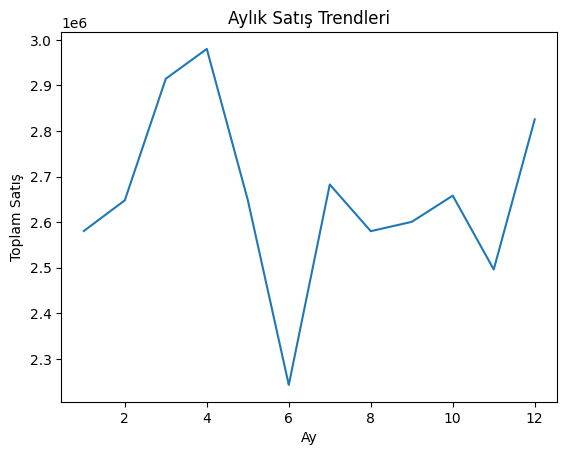

In [2]:
import matplotlib.pyplot as plt

# Tarih sütununu datetime formatına çevirme
merged_data['tarih'] = pd.to_datetime(merged_data['tarih'])

# Hafta ve ay bilgilerini çıkarma
# Satış tarihinden hafta bilgilerini alıyoruz
merged_data['hafta'] = merged_data['tarih'].dt.isocalendar().week

# Satış tarihinden ay bilgisini alıyoruz
merged_data['ay'] = merged_data['tarih'].dt.month

# Haftalık ve aylık toplam satışlar
# Haftalık toplam satışları gruplayarak hesaplıyoruz
weekly_sales = merged_data.groupby('hafta')['toplam_satis'].sum()
# Aylık toplam satışları gruplayarak hesaplıyoruz
monthly_sales = merged_data.groupby('ay')['toplam_satis'].sum()

# Grafik 
plt.plot(monthly_sales)
plt.title("Aylık Satış Trendleri")
plt.xlabel("Ay")
plt.ylabel("Toplam Satış")
plt.show()


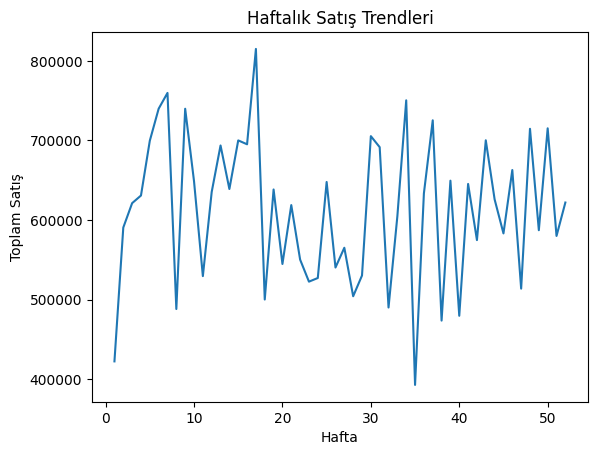

In [3]:
# Grafik
plt.plot(weekly_sales)
plt.title("Haftalık Satış Trendleri")
plt.xlabel("Hafta")
plt.ylabel("Toplam Satış")
plt.show()


In [4]:
# Kategorik analiz: Ürün kategorilerine göre satış
# Kategori bazında toplam satışları hesaplıyoruz
category_sales = merged_data.groupby('kategori')['toplam_satis'].sum()

# Yaş gruplarına göre satışlar
# Yaş gruplarını belirliyoruz (18-25, 26-35, 36-50, 50+)
age_bins = [0, 25, 35, 50, np.inf]
age_labels = ['18-25', '26-35', '36-50', '50+']
merged_data['age_group'] = pd.cut(merged_data['yas'], bins=age_bins, labels=age_labels)

# Yaş gruplarına göre toplam satışları hesaplıyoruz
age_group_sales = merged_data.groupby('age_group')['toplam_satis'].sum()
# Cinsiyet bazında toplam harcama miktarlarını hesaplıyoruz
gender_spending = merged_data.groupby('cinsiyet')['harcama_miktari'].sum()


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14620\3957931474.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_sales = merged_data.groupby('age_group')['toplam_satis'].sum()


In [5]:
# Şehir bazında toplam harcama miktarlarını hesaplıyoruz
city_spending = merged_data.groupby('sehir')['harcama_miktari'].sum()
# Önceki aya ait satış verilerini alıyoruz
merged_data['previous_month_sales'] = merged_data.groupby('ürün_kodu')['toplam_satis'].shift(1)
# Satış değişim yüzdesini hesaplıyoruz
merged_data['sales_change_percentage'] = (merged_data['toplam_satis'] - merged_data['previous_month_sales']) / merged_data['previous_month_sales'] * 100
# Aylık kategorik satış değişim oranı hesaplama
monthly_category_sales = merged_data.groupby(['kategori', 'ay'])['toplam_satis'].sum()
monthly_category_sales_percentage_change = monthly_category_sales.pct_change() * 100


In [6]:
# Pareto analizi
# Ürün kodlarına göre toplam satışları hesaplıyoruz ve azalan sırayla sıralıyoruz
pareto_data = merged_data.groupby('ürün_kodu')['toplam_satis'].sum().sort_values(ascending=False)
# Pareto verisi için kümülatif satış yüzdesini hesaplıyoruz
pareto_data_cumulative = pareto_data.cumsum() / pareto_data.sum()
# Pareto ürünlerini 80/20 kuralına göre seçiyoruz
pareto_products = pareto_data[pareto_data_cumulative <= 0.8]
# Cohort analizi: İlk satın alma ayına göre müşteri analizi
merged_data['first_purchase_month'] = merged_data.groupby('musteri_id')['tarih'].transform('min').dt.to_period('M')
merged_data['tarih_month'] = merged_data['tarih'].dt.to_period('M')
# Müşterilerin ilk satın alma ayına göre cohort analizini yapıyoruz
cohort_data = merged_data.groupby(['first_purchase_month', 'tarih_month']).size().unstack(fill_value=0)


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
# Satış tahmini modeli
X = merged_data[['fiyat', 'adet']]  
y = merged_data['toplam_satis'] 

# Eğitim ve test verilerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Modeli oluşturma ve eğitme
model = LinearRegression()
model.fit(X_train, y_train)
# Model doğruluğu
score = model.score(X_test, y_test)
print(f"Modelin doğruluk skoru: {score:.2f}")


Modelin doğruluk skoru: 0.87


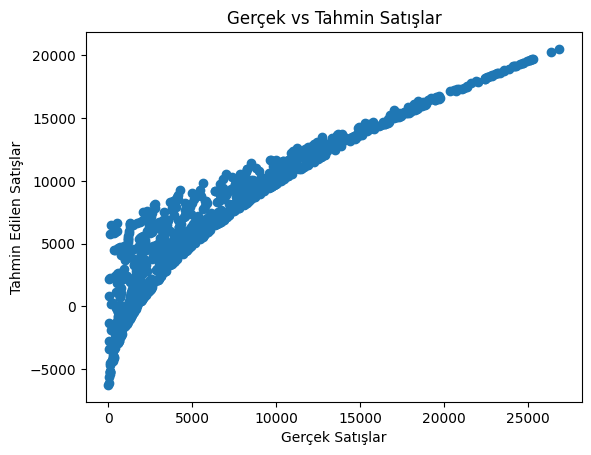

In [7]:
y_pred = model.predict(X_test)
plt.scatter(y_test, y_pred)
plt.title("Gerçek vs Tahmin Satışlar")
plt.xlabel("Gerçek Satışlar")
plt.ylabel("Tahmin Edilen Satışlar")
plt.show()